In [39]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydeck as pdk

import sklearn.neighbors


from util import mapping
from util import config
from util import get_data
from util import clean_data
from util import process_data


## Engineering difficulty features

"Ride difficulty" is very subjective, but it can probably be boiled down to some combination of how far you have to go and how steep the hills are along the way.  Here, I try out a bunch of different features that seem of possible interest, based on my domain knowledge.

These features are all at the 'trip' level - i.e. a single value for an entire ride.  They may not match up with the 'trip' level data that we have been using so far, as the total distance for a ride given by the RideWithGPS API is not necessarily the same as the total distance measured from our cleaned-up ride-level lat/lon breadcrumbs.

Note that I am not using any features that are specific to a ride, rather than a route, e.g. average speed.  This will obviously impact the difficulty of the ride, but it is not intrinsic to the suggested route in the way that metrics to do with the number of miles travelled and feet climbed do.

The chosen features are detailed in the function  <i>process_data.calc_features()</i>

In [81]:
# Extract features from the data, using unique ride IDs
RTE_IDS = pd.read_feather(
    os.path.join(config.PROCESSED_DATA_PATH, 'deduped_rte_ids.feather')
)
# Only need ride IDs, as will load in ride files separately
trips_unscaled = process_data.get_features_from_rte_files(RTE_IDS.rte_id.values)
trips_unscaled.drop('rte_id', axis=1).describe()

0
1000
2000
3000
4000
5000
6000


,dist,avg_slope_climbing,avg_slope_descending,max_slope,dist_climbing,dist_downhill,dist_6percent,dist_9percent,dist_12percent
count,5876.000000,5876.000000,5876.000000,5876.000000,5876.000000,5876.000000,5876.000000,5876.000000,5876.000000
mean,38.221301,4.023727,-2.935754,12.805011,0.145497,0.094341,0.049059,0.016852,0.005636
std,21.317573,1.369062,1.067241,4.682688,0.080283,0.065187,0.047829,0.026228,0.013867
min,2.547753,0.000000,-11.933929,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.933025,3.074173,-3.299352,9.509320,0.087458,0.046127,0.015856,0.000957,0.000000
50%,34.779413,3.795408,-2.728227,12.476724,0.135877,0.084247,0.035820,0.007740,0.000483
75%,50.003383,4.731057,-2.301866,15.899691,0.194251,0.130107,0.068238,0.021697,0.005414
max,122.442250,11.907143,0.000000,24.999891,0.599743,0.635279,0.493740,0.408974,0.246061


Note that there is a lot of collinearity in this dataset!  This is deliberate - ride difficulty can only come from some combinations of the horizontal and vertical distances travelled, i.e. ride length; amount of climbing.

However, how exactly the horizontal and vertical distances are combined is very important!  Clearly, a ride that is flat with a relatively short section at 20% slope is going to be much harder than a ride that is 5% for 4 times as long - yet both have the same distance travelled, the same elevation gain, the same average slope.

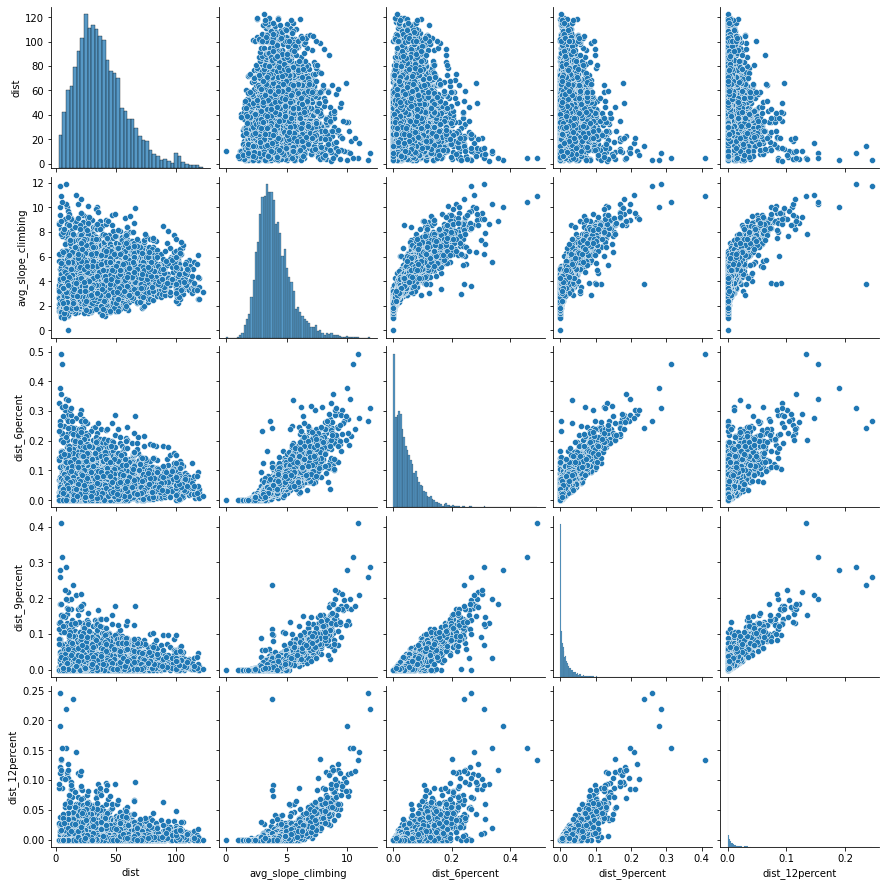

In [27]:
sns.pairplot(trips_unscaled[
    [col for col in trips_unscaled.columns 
     if 'percent' in col or col in ['dist', 'avg_slope_climbing']]
])

Note as well that some features have a strong positive skewness - this is basically because the bell curve is cut off when it reaches 0.  To address this, we can use the log of the highly skewed features.

In [84]:
trips_eng = process_data.engineer_normal_features(trips_unscaled)
trips_eng.set_index('rte_id', inplace=True)

Now we need to scale the data, so that e.g. ride length (range 0 to 125 miles) does not overwhelm features like avg_slope (range 0 to 12).

In [83]:
trips_scaled, scale_df = process_data.scale_dataset(trips_eng)

config.save_df(scale_df.reset_index(), config.MODEL_PATH,
              'feature_scaling.feather')
scale_df

,dist,avg_slope_climbing,avg_slope_descending,max_slope,dist_climbing,dist_downhill,dist_6percent,dist_9percent,dist_12percent
mean,3.469746,4.023727,-2.935754,12.805011,0.145497,0.094341,-3.122017,-3.890451,-4.310759
std,0.634557,1.368945,1.067150,4.682289,0.080276,0.065182,0.785466,0.676075,0.460927


## Get insight on the feature importances for difficulty

This dataset is unlabelled, so it is harder to make inferences about which features are significant to ride difficulty.  For example, I could (a) work with domain knowledge to prescribe these a priori; (b) perform some clustering analysis to try and get a sense for which features tend to go with each other in this particular dataset; (c) hand label some examples and try to infer from a smaller, labelled dataset.

Option (a) is challenging because it is very hard to have real confidence in.  Option (b) would really just inform options (a) or (c).  Option (c) is suboptimal because I have not been on more than a handful of these rides, so I don't even have a (highly subjective!) opinion about how difficult they are.

Fortunately, there are some hand-labels that I can use! The local guide book, "Backroad Bicycling in the Hudson Valley and Catskills" by Peter Kick and Dori O'Connell, rates each of their suggested rides as 'Easy', 'Moderate', or 'Strenuous'.  I have loaded all of these rides into RideWithGPS, so I can download and process the data in a similar way.  I then perform a logistic regression to try to identify important features.

In [44]:
# These are the ride IDs, used to locate the rides in the RideWithGPS API
book_ids = {
    'easy': [34334830, 34334875, 34334946, 34334973, 34334993, 
             34335057, 34335164, 34335190, 34335257],
    'moderate': [34334760, 34334840, 34334850, 34334931, 34335019,
                  34335063, 34335072, 34335087, 34335143, 34335210,
                  34335223, 34335265, 34335284, 34335362, 34335395],
    'strenuous': [34334791, 34334812, 34334864, 34334890, 
               34334909, 34334917, 34334959, 34335041,
               34335104, 34335111, 34335122, 34335154,
               34335236, 34335379],
}

Download, clean, and save all of the book routes.

Note that these routes still need cleaning as there are imperfections, e.g. in the DEM (digital elevation model), such that features like the slope can return crazy values.  The cleaning step also renames columns, and calculates some additional features (e.g. slope from elevation).

It also calculates e.g. speed using time information, which I just fill here with a dummy value so it doesn't throw an error.

In [50]:
# Note: Do not rerun this cell casually - it downloads data!
for rte_id in [i for v in book_ids.values() for i in v]:
    print(rte_id)
    rte_df = get_data.ridewithgps_api_ride(rte_id, 'routes', False)
    
    rte_df['t'] = 0 # Need to add this column for clean_data.clean_single_trip()
    rte_df = clean_data.clean_single_trip(rte_df)
    rte_df['rte_id'] = rte_id
    config.save_df(rte_df, config.CLEAN_TRIPS_PATH,
                   'route_{}.feather'.format(rte_id))

34334830
34334875
34334946
34334973
34334993
34335057
34335164
34335190
34335257
34334760
34334840
34334850
34334931
34335019
34335063
34335072
34335087
34335143
34335210
34335223
34335265
34335284
34335362
34335395
34334791
34334812
34334864
34334890
34334909
34334917
34334959
34335041
34335104
34335111
34335122
34335154
34335236
34335379


In [100]:
# Generate ride features, as with real data
book_routes_orig = process_data.get_features_from_rte_files(
    ['route_{}'.format(rte_id) for v in book_ids.values() for rte_id in v]
)
book_routes_orig = book_routes_orig.set_index('rte_id').fillna(0)


0


What we are ultimately interested in:

* Which features are significant?
* How should significant features be weighted with respect to each other in the nearest-neighbours algorithm?

For the first point, I am going to use LASSO regression.  This also helps to deal with the multicollinearity problem identified earlier.

As to the second, feature weights are much more useful in this context from a binary classification.  I don't want to classify each ride as 'Easy', 'Moderate', or 'Strenuous' (as my labelled data set is too small).  Instead, I want to use the feature weights to guide the relative weighting.  With multiclass classification, there is more than one decision boundary, so it is not as straightforward to use in this context.

Other good reasons to use a binary classification:

* There are relatively few 'easy' rides, so I can rebalance my classes by merging 'easy/moderate' and comparing to 'strenuous'
* The dataset is very small, so even a binary classification is somewhat ambitious!


Note that because we are using the scaling from the data, this data is not actually centred.  For example, these rides are on average shorter and slightly less steep than the rides in the database.

In [101]:
s_ids = ['route_{}'.format(v) for v in book_ids['strenuous']]

book_routes_orig['rating'] = 'easy'
book_routes_orig.loc[s_ids, 'rating'] = 'hard'

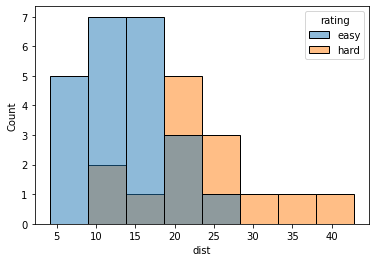

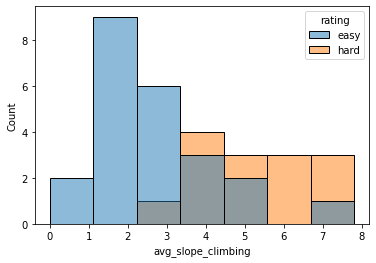

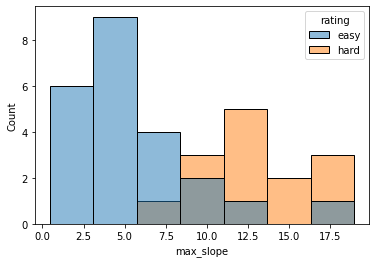

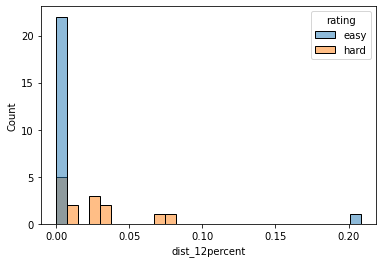

In [104]:
colours = sns.color_palette('husl', 3)

for col in ['dist', 'avg_slope_climbing', 'max_slope', 'dist_12percent']:
    if col == 'rating': continue
    plt.figure()
    sns.histplot(book_routes_orig, x=col, hue='rating')

Most of these plots show a relatively clear distinction between the 'easy' and 'hard' routes - so this should be an ok decision boundary.

However, we can see there is clearly a problem with one of the 'easy' rides - it should definitely not be going above 12% slope for over 1/5 of the ride!

In [106]:
book_routes_orig[book_routes_orig.dist_12percent > 0.15]

,dist,avg_slope_climbing,avg_slope_descending,max_slope,dist_climbing,dist_downhill,dist_6percent,dist_9percent,dist_12percent,rating
rte_id,,,,,,,,,,
route_34334973,6.71499,7.299312,-1.555338,17.407868,0.609237,0.0,0.311218,0.311218,0.208228,easy


When plotting the data, there are clearly some errors in the slope data, and because I have smoothed the slope, these persist!  This ride is unusable.

Text(0.5, 1.0, 'Bad route: 34334973')

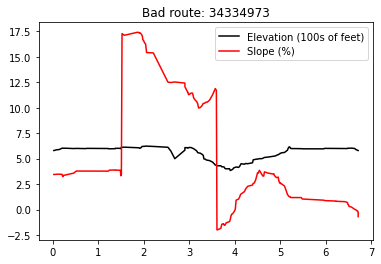

In [121]:
bad_rte = pd.read_feather(os.path.join(config.CLEAN_TRIPS_PATH,
                      'route_{}.feather'.format(34334973)))
plt.plot(np.cumsum(bad_rte.dist), bad_rte.elevation/100, 'k-', label='Elevation (100s of feet)')
plt.plot(np.cumsum(bad_rte.dist), bad_rte.slope, 'r-', label='Slope (%)')
plt.legend()
plt.title('Bad route: 34334973')

In [102]:
# And scale it etc in the same way as the real data
book_routes = process_data.engineer_normal_features(book_routes_orig)
book_routes = process_data.apply_scaling(book_routes)
book_routes.describe()

,dist,avg_slope_climbing,avg_slope_descending,max_slope,dist_climbing,dist_downhill,dist_6percent,dist_9percent,dist_12percent
count,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000
mean,-1.125520,-0.266771,-0.508006,-0.957595,0.181357,0.605605,-0.207425,0.130959,0.289225
std,0.799048,1.461670,1.846498,1.132167,1.705408,1.593612,1.643196,1.658174,1.715270
min,-3.237620,-2.939289,-6.264180,-2.639519,-1.812463,-1.447344,-1.888246,-1.057159,-0.638736
25%,-1.474814,-1.446851,-1.394854,-1.966226,-1.508101,-0.797483,-1.888246,-1.057159,-0.638736
50%,-1.113816,-0.403700,-0.263293,-1.141934,0.262941,0.368901,-0.221385,-1.057159,-0.638736
75%,-0.651401,0.715556,0.780021,0.057405,1.142199,1.549109,1.425962,1.395438,1.141970
max,0.455164,2.763639,2.751023,1.313350,5.776813,3.999507,2.627545,4.074716,6.049861
